In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchio as tio
import matplotlib.pyplot as plt
from torchvision import ops

from glio import nn as gnn
from glio.nn import conv, convt, linear
from glio.torch_tools import summary, lr_finder
from glio.train import *
from glio.data.DS import DSToTarget
from glio.datasets import LUMIERE
from glio.python_tools import CacheRepeatIterator
from glio.jupyter_tools import clean_mem, show_slices, show_slices_arr
from glio.visualize import vis_imshow_grid, vis_imshow, Visualizer
from glio.loaders import nifti
from glio.train import *
from glio.points import Point, BoundingBox, draw_point, draw_bbox, bbox_from_xxdd as xxdd

## Загрузчик
Загрузчик возращает `[T1, Mask, BBox]`.

Чёрную область вокруг изображения можно удалить `[25:-25,25:-35,20:-20]`.

Получаем `132, 158, 142`

Трансформация берёт каждый 9 саггитальный срез, получаем 16 срезов из 142. Можно потом попробовать воспользоваться изменением размера.


### mean / std
- T1 image - `3567939758e+01`; `161.2564239502`
- FLAIR image - `5.9002014160e+01`; `129.0489959717`
- T1 mask - `2.4059068412e-02`; `0.2359057516`


In [2]:
lum = LUMIERE.LUMIERE()
print(lum.col_names())

slices = [slice(25,-25),slice(25,-35),slice(20,-20)]
ch_slices = [slice(None), *slices]
d = lum.get_cols(["T1 image", "T1 mask", "T1 contrast-enhancing bbox"])

mean_std = (7.3567939758e+01, 0), (161.2564239502, 1)
def normalize(x:torch.Tensor):
    return (x - x.mean()) / x.std()


def loader(x: dict):
    img3d = torch.stack(((nifti.read(x["T1 image"])), nifti.read(x["T1 mask"])))[:,*slices].permute(0,3,2,1)
    shape = img3d.shape
    img3d = img3d[:, ::9]
    img3d[0] = normalize(img3d[0])
    mask = F.one_hot(img3d[1].to(torch.int64)).permute(3, 0, 1, 2)
    return img3d[0], mask, xxdd(x["T1 contrast-enhancing bbox"], arr=shape).crop(slices).permute(2,1,0).translate(img3d).center()
    #bbox = x["T1 contrast-enhancing bbox"]

sample_idx = 1
sample_img, sample_mask, sample_bbox = loader(d[sample_idx])
print(f"{sample_img.shape = }, {sample_mask.shape = }")
print(f"{sample_img.min() = }, {sample_img.max() = }, {sample_img.mean() = }, {sample_img.std() = }")#type:ignore
print(f"{sample_mask.min() = }, {sample_mask.max() = }, {sample_mask.dtype = }")#type:ignore
print(sample_bbox)

def transform_init(x: tuple[torch.Tensor,torch.Tensor, Point]): return x
def transform_sample(x: tuple[torch.Tensor,torch.Tensor, Point]):
    return x[0]
def transform_target(x: tuple[torch.Tensor,torch.Tensor, Point]):
    return x[1], x[2].to_rel().coords

ds = DSToTarget()
ds.add_samples(d, loader, transform_init, transform_sample, transform_target)
print(len(ds))
ds_train, ds_test = ds.split(0.85)
mean_std = ds_train.get_mean_std(16, 8)
print(len(ds_train), len(ds_test))
print(mean_std)

#ds_train.preload(0.5)
#ds_test.preload(0.5)

['Patient', 'Survival time (weeks)', 'Sex', 'Age at surgery (years)', 'IDH (WT: wild type)', 'IDH method', 'MGMT qualitative', 'MGMT quantitative', 'Date', 'LessThan3Months', 'NonMeasurableLesions', 'RANO', 'bbox', 'CT1 image', 'CT1 mask', 'CT1 necrosis bbox', 'CT1 hga-image', 'CT1 hga-mask', 'CT1 hga-non-enhancing bbox', 'CT1 hga-contrast-enhancing bbox', 'T1 hga-image', 'T1 hga-mask', 'T1 hga-non-enhancing bbox', 'T1 hga-contrast-enhancing bbox', 'T2 hga-image', 'T2 hga-mask', 'T2 hga-non-enhancing bbox', 'T2 hga-contrast-enhancing bbox', 'FLAIR hga-image', 'FLAIR hga-mask', 'FLAIR hga-non-enhancing bbox', 'FLAIR hga-contrast-enhancing bbox', 'CT1 contrast-enhancing bbox', 'CT1 edema bbox', 'T1 image', 'T1 mask', 'T1 necrosis bbox', 'T1 contrast-enhancing bbox', 'T1 edema bbox', 'T2 image', 'T2 mask', 'T2 necrosis bbox', 'T2 contrast-enhancing bbox', 'T2 edema bbox', 'FLAIR image', 'FLAIR mask', 'FLAIR necrosis bbox', 'FLAIR contrast-enhancing bbox', 'FLAIR edema bbox']
sample_img.sh

## Модель

In [3]:
class CNN_Base_center(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_Base_center(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_Base_bbox/conv1/0               torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6168      0         
__main__.CNN_Base_bbox/conv1/1               torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_Base_bbox/conv2/0               torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6944      0         
__main__.CNN_Base_bbox/conv2/1               torch.nn.modules.activation.GELU             (8, 32, 38, 32)          (8, 32, 38, 32)          0         0         
__main__.CNN_Base_bbox/conv3/0               torch.nn.modules.conv.Conv2d                 (8, 32, 38, 32)          (8, 48, 19, 16)          6192      0         
__main__.CNN_Base_bbox/conv3/1    

In [4]:
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_Base_center()
opt = optim.AdamW(model.parameters())
lrs, losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=2)
1

1

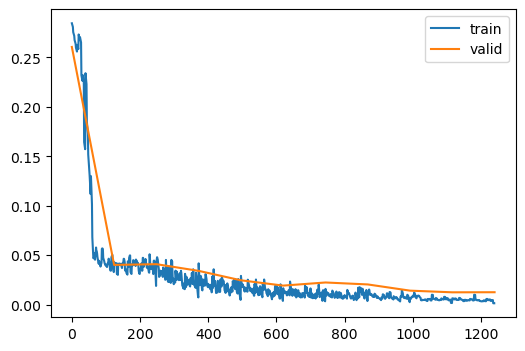

Training took 2845.817489799927 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.0014460874954238534
 - best train MSE loss: learner.logger.min("train loss") = 0.0014460874954238534

 - last test MSE loss: learner.logger.last("test loss") = 0.01261842188735803
 - best test MSE loss: learner.logger.min("test loss") = 0.012528281658887863


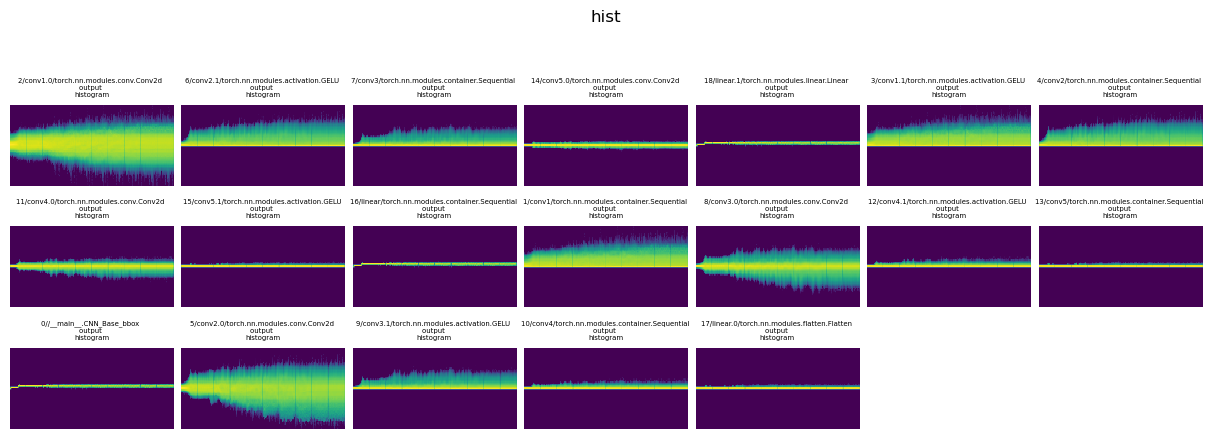

In [5]:
MODEL = CNN_Base_center()
NAME = MODEL.__class__.__name__
LR = 1e-3
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

clean_mem()
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE), CACHE_ELEMS)
# dl_train = DataLoader(ds_train, BATCH_SIZE)
dl_test = DataLoader(ds_test, BATCH_SIZE)
#model = gnn.LSUV(model, dl_train)
opt = optim.AdamW(MODEL.parameters(), lr=LR)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

CP_FOLDER = "LUMIERE checkpoints"
learner = Learner(MODEL, f"LUMIERE {NAME}",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=4),
                         Log_SignalHistorgram(4), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')

plt.show()
learner.logger.hist_all("hist")

# Addding batch norm

In [3]:
class CNN_BatchNorm_center(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_BatchNorm_center(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_BatchNorm_center/conv1/0        torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_BatchNorm_center/conv1/1        torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_BatchNorm_center/conv1/2        torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_BatchNorm_center/conv2/0        torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_BatchNorm_center/conv2/1        torch.nn.modules.activation.GELU             (8, 32, 38, 32)          (8, 32, 38, 32)          0         0         
__main__.CNN_BatchNorm_center/conv

Iteration 1 done.14866821 loss: 0.681303679943084754


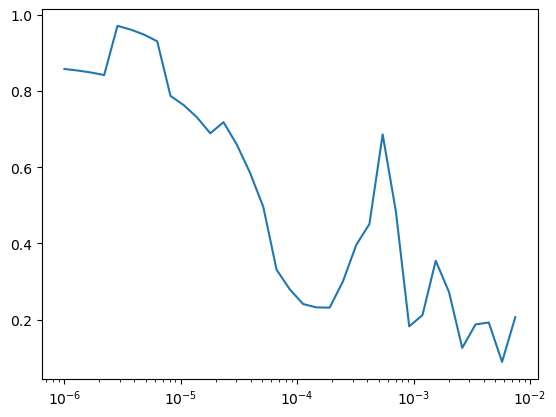

In [7]:
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_BatchNorm_center()
opt = optim.AdamW(model.parameters())
lrs, losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=2)

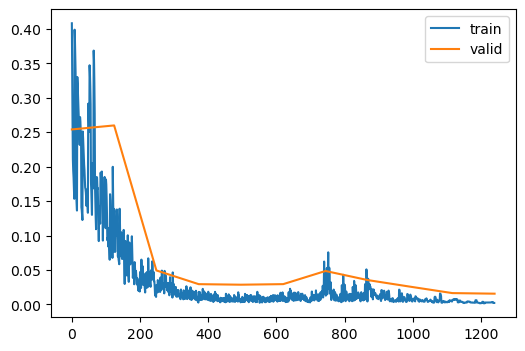

Training took 2763.8142563999863 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.0021196852903813124
 - best train MSE loss: learner.logger.min("train loss") = 0.001651252037845552

 - last test MSE loss: learner.logger.last("test loss") = 0.015597713800768057
 - best test MSE loss: learner.logger.min("test loss") = 0.015597713800768057


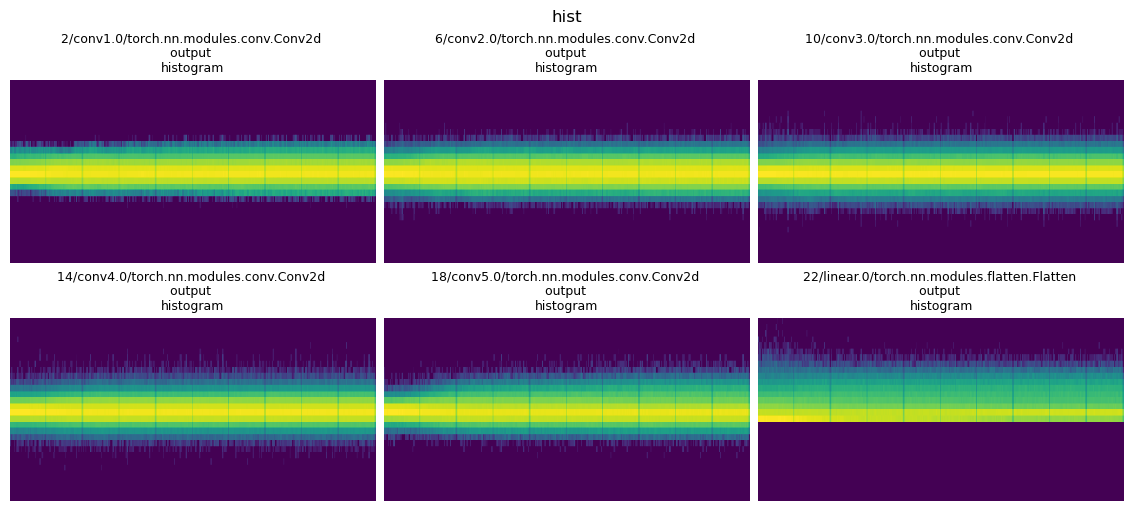

In [4]:
MODEL = CNN_BatchNorm_center()
NAME = MODEL.__class__.__name__
LR = 1e-3
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

clean_mem()
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE), CACHE_ELEMS)
# dl_train = DataLoader(ds_train, BATCH_SIZE)
dl_test = DataLoader(ds_test, BATCH_SIZE)
# model = gnn.LSUV(model, dl_train)
opt = optim.AdamW(MODEL.parameters(), lr=LR)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

CP_FOLDER = "LUMIERE checkpoints"
learner = Learner(MODEL, f"LUMIERE {NAME}",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=4),
                         Log_SignalHistorgram(4), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')

plt.show()
learner.logger.hist_all("hist")

# Using LSUV instead of batchnorm

In [3]:
class CNN_LSUV_center(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_LSUV_center(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_LSUV_center/conv1/0             torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6168      0         
__main__.CNN_LSUV_center/conv1/1             torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_LSUV_center/conv2/0             torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6944      0         
__main__.CNN_LSUV_center/conv2/1             torch.nn.modules.activation.GELU             (8, 32, 38, 32)          (8, 32, 38, 32)          0         0         
__main__.CNN_LSUV_center/conv3/0             torch.nn.modules.conv.Conv2d                 (8, 32, 38, 32)          (8, 48, 19, 16)          6192      0         
__main__.CNN_LSUV_center/conv3/1  

[0.026, -0.007, 0.004, 0.01, 0.0], [1.012, 1.009, 1.026, 1.017, 1.0], [11, 11, 11, 11, 11], 9]
Iteration 1 done.2730359 loss: 0.1006874293088913516


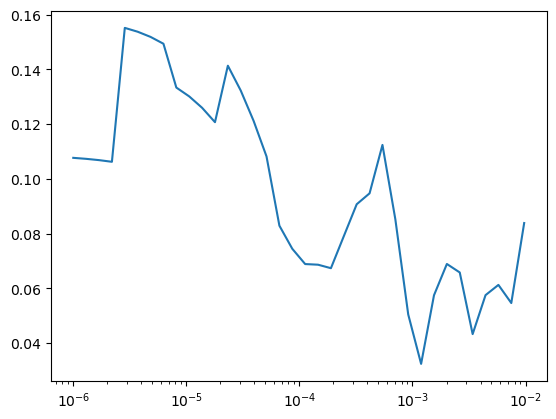

In [5]:
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = gnn.LSUV(CNN_LSUV_center(), dl_train)
opt = optim.AdamW(model.parameters())
lrs, losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=2)

In [ ]:
MODEL = CNN_LSUV_center()
NAME = MODEL.__class__.__name__
LR = 1e-3
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

clean_mem()
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE), CACHE_ELEMS)
# dl_train = DataLoader(ds_train, BATCH_SIZE)
dl_test = DataLoader(ds_test, BATCH_SIZE)
model = gnn.LSUV(model, dl_train)
opt = optim.AdamW(MODEL.parameters(), lr=LR)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

CP_FOLDER = "LUMIERE checkpoints"
learner = Learner(MODEL, f"LUMIERE {NAME}",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=4),
                         Log_SignalHistorgram(4), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')

plt.show()
learner.logger.hist_all("hist")

# Adding orthogonal init with LSUV

# Adding dropout

In [ ]:
class CNN_Dropout_bbox(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.5, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.6, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.65, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.7, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_Dropout_bbox(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_Dropout_bbox/conv1/0            torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_Dropout_bbox/conv1/1            torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_Dropout_bbox/conv1/2            torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_Dropout_bbox/conv1/3            torch.nn.modules.dropout.Dropout2d           (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_Dropout_bbox/conv2/0            torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_Dropout_bbox/conv2/1 

Iteration 9 done.0002e-06 loss: 2.16568326950073247


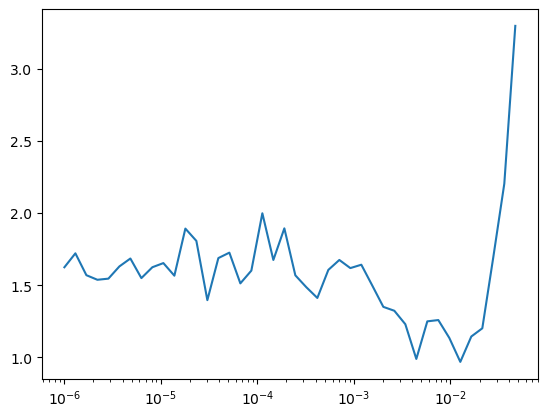

1

In [16]:
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_Dropout_bbox()
opt = optim.AdamW(model.parameters())
lrs,losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=10)

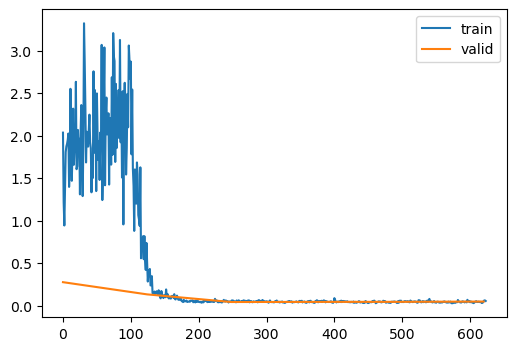

Keyboard interrupt, stopping the training...


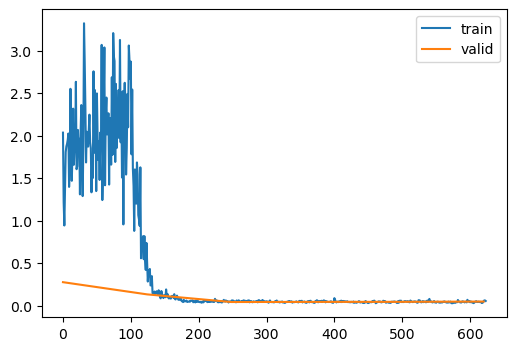

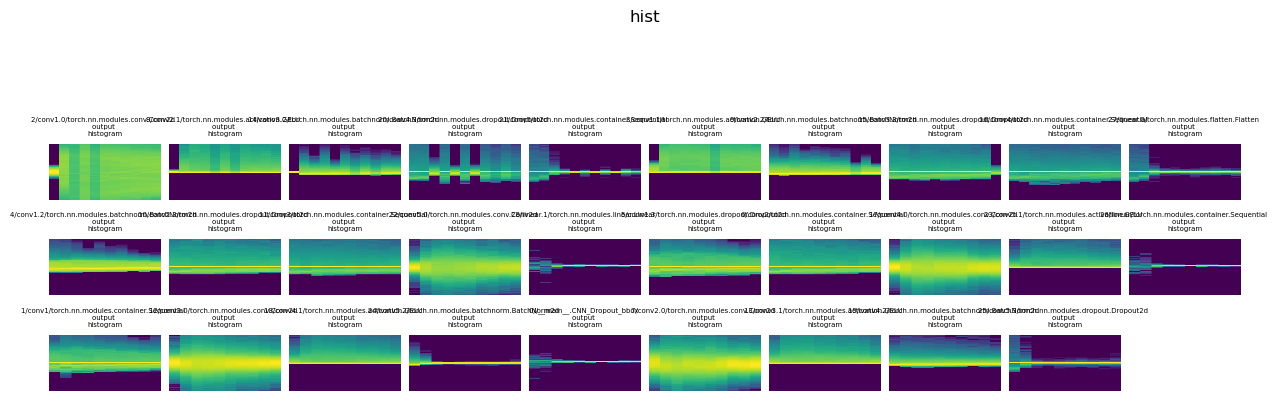

learner.logger.last("train loss") = 0.05587853491306305


In [ ]:
clean_mem()
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))

import matplotlib.pyplot as plt

lr = 1e-3
batch_size = 16
cache_elems = 4
n_epochs = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, batch_size), cache_elems)
dl_test = DataLoader(ds_test, batch_size)
model = CNN_Base_bbox()
#model = gnn.LSUV(CNN_Base(), dl)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(dl_train), epochs=n_epochs)

learner = Learner(model, "LUMIERE1 CNNDropout",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=8), Log_SignalHistorgram(4)],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(n_epochs, dl_train, dl_test)

from glio.train.cbs_log import Log_Preds, Log_PredsSep, Write_Preds
print(f'{learner.logger.last("MSE train loss") = }')
print(f'{learner.logger.last("MSE test loss") = }')
learner.logger.save(f"{learner.name} logger.npz")
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()], without="FastProgressBar")
print(f'L1 {learner.logger.last("test loss") = }')
plt.show()
learner.logger.hist_all("hist")

learner.logger.last("test loss") = 0.049236744021375976


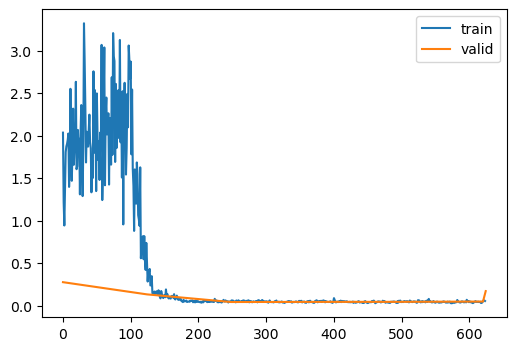

l1: learner.logger.last("test loss") = 0.17217074086268744


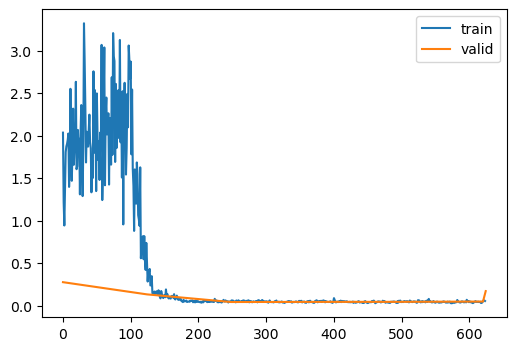

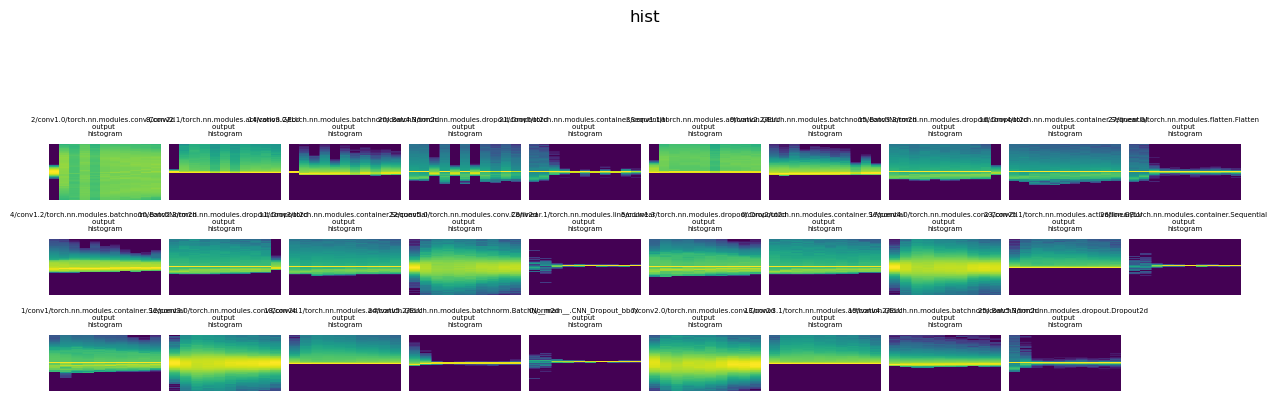

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (7, 2) + inhomogeneous part.

In [15]:
print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()])
print(f'l1: {learner.logger.last("test loss") = }')
learner.logger.hist_all("hist")
learner.logger.save("LUMIERE1 bbox CNN Base + Dropout logger.npz")

In [13]:
class CNN_NiN_bbox(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.5, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.6, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.65, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.7, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.nin = conv(64, 3, 1, act=nn.GELU(), pool=nn.AvgPool2d(4, 1))
        self.flatten = nn.Flatten()
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.flatten(self.nin(x))

summary(CNN_NiN_bbox(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_NiN_bbox/conv1/0                torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_NiN_bbox/conv1/1                torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_NiN_bbox/conv1/2                torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_NiN_bbox/conv1/3                torch.nn.modules.dropout.Dropout2d           (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_NiN_bbox/conv2/0                torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_NiN_bbox/conv2/1     

Iteration 9 done.539266 loss: 0.28227430582046517686


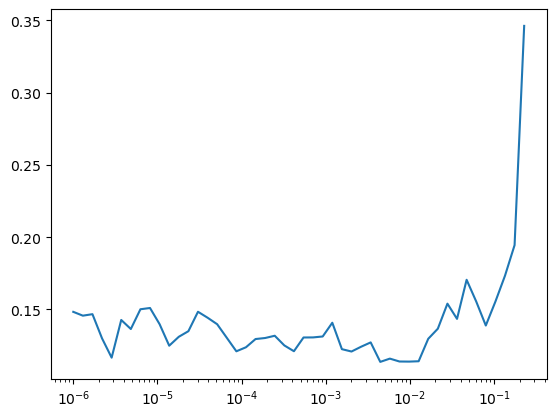

1

In [ ]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_NiN_bbox()
opt = optim.AdamW(model.parameters())
lrs,losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=10)
1

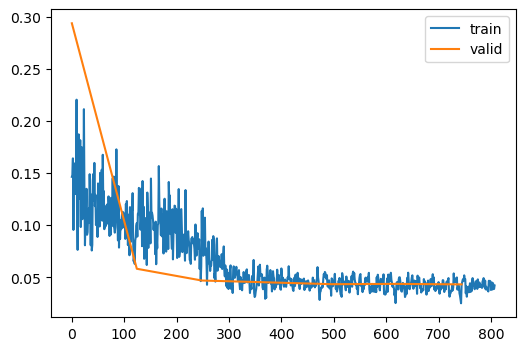

Keyboard interrupt, stopping the training...


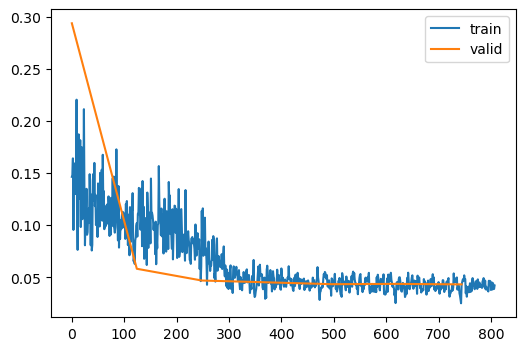

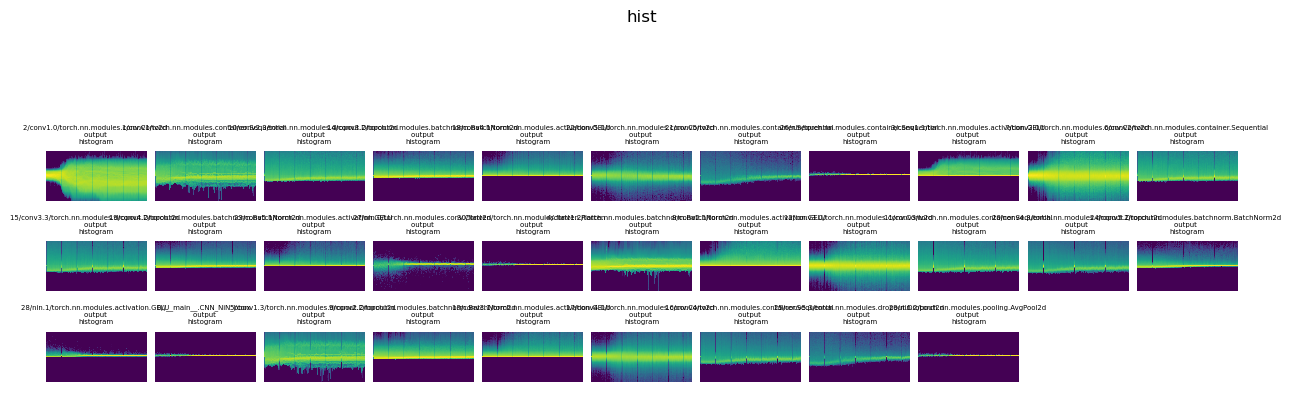

learner.logger.last("train loss") = 0.042121924459934235
learner.logger.last("test loss") = 0.043197873358925186
l1: learner.logger.last("test loss") = 0.17717680831750235


In [14]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))

import matplotlib.pyplot as plt
clean_mem()
lr = 9e-3
batch_size = 16
cache_elems = 4
n_epochs = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, batch_size), cache_elems)
dl_test = DataLoader(ds_test, batch_size)
model = CNN_NiN_bbox()
#model = gnn.LSUV(CNN_Base(), dl)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(dl_train), epochs=n_epochs)

learner = Learner(model, "LUMIERE1 CNNBase",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Log_SignalHistorgram(4), Log_Preds()],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(n_epochs, dl_train, dl_test)
plt.show()
learner.logger.hist_all("hist")
print(f'{learner.logger.last("train loss") = }')

print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()], ["FastProgressBar"])
print(f'l1: {learner.logger.last("test loss") = }')

In [11]:
class CNN_LMConv_bbox(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.5, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.6, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.65, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.7, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.lmconv = nn.Sequential(gnn.ChannelConcat(gnn.LMConv((16,16), 64),gnn.LMConv((16,16), 64),gnn.LMConv((16,16), 64)), nn.GELU(), nn.AvgPool2d(13, 1))
        self.flatten = nn.Flatten()
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.flatten(self.lmconv(x))

summary(CNN_LMConv_bbox(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_LMConv_bbox/conv1/0             torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_LMConv_bbox/conv1/1             torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_LMConv_bbox/conv1/2             torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_LMConv_bbox/conv1/3             torch.nn.modules.dropout.Dropout2d           (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_LMConv_bbox/conv2/0             torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_LMConv_bbox/conv2/1  

Iteration 9 done.4114308 loss: 0.2622882723808288632


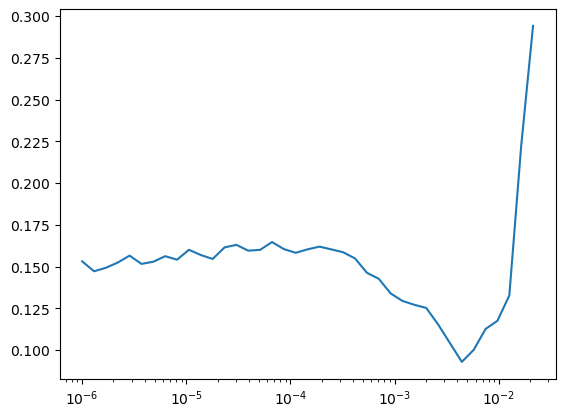

1

In [14]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
model = CNN_LMConv_bbox()
opt = optim.AdamW(model.parameters())
lrs,losses = lr_finder(model, opt, loss, dl_train,mul=1.3, end = 1, niter=10)
1

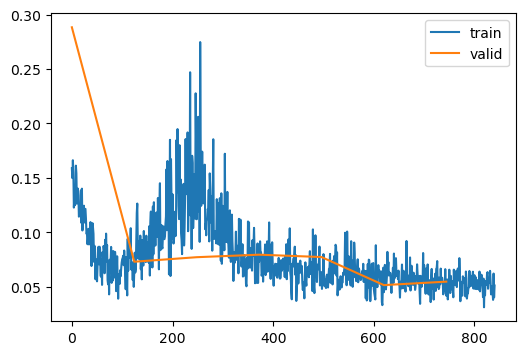

MemoryError: 

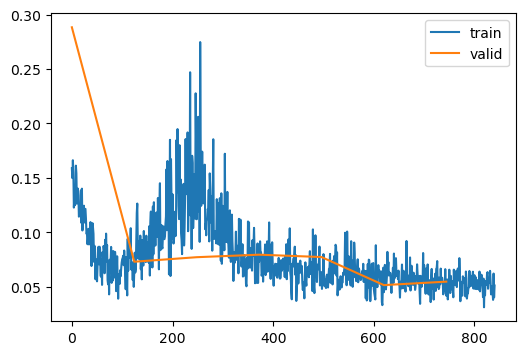

In [12]:
from glio.python_tools import CacheRepeatIterator
dl_train = CacheRepeatIterator(DataLoader(ds_train, 16), 4)
loss_fn = nn.MSELoss()
def loss(x, y:tuple):
    return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))

import matplotlib.pyplot as plt
clean_mem()
lr = 8e-3
batch_size = 16
cache_elems = 4
n_epochs = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, batch_size), cache_elems)
dl_test = DataLoader(ds_test, batch_size)
model = CNN_LMConv_bbox()
#model = gnn.LSUV(CNN_Base(), dl)
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, steps_per_epoch=len(dl_train), epochs=n_epochs)

learner = Learner(model, "LUMIERE1 CNNBase",
                  cbs = [Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Log_SignalHistorgram(4), Log_Preds()],
                  loss_fn=loss,
                  optimizer=opt,
                  scheduler=sched)
learner.fit(n_epochs, dl_train, dl_test)
plt.show()
learner.logger.hist_all("hist")
print(f'{learner.logger.last("train loss") = }')

print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()], ["FastProgressBar"])
print(f'l1: {learner.logger.last("test loss") = }')

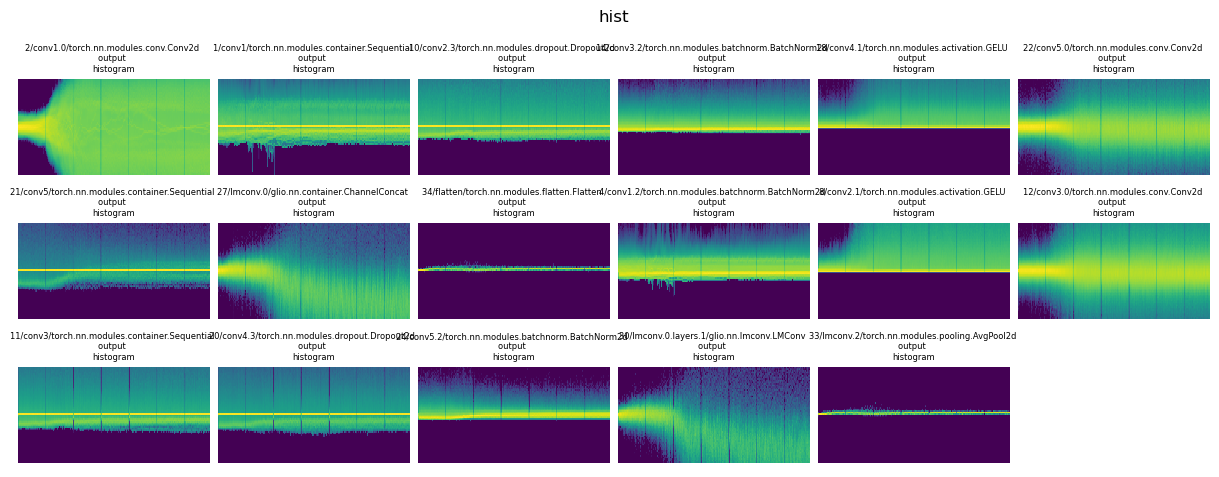

learner.logger.last("train loss") = 0.05128335580229759
learner.logger.last("test loss") = 0.05461709573864937


MemoryError: Unable to allocate output buffer.

In [13]:
learner.logger.hist_all("hist")
print(f'{learner.logger.last("train loss") = }')

print(f'{learner.logger.last("test loss") = }')
def l1loss(x, y:tuple):
    return F.l1_loss(x, (torch.stack(y[1]).T).to(torch.float32))
learner.fit(1, None, dl_test, False, [Set_LossFn(l1loss), Log_Preds()], ["FastProgressBar"])
print(f'l1: {learner.logger.last("test loss") = }')

In [ ]:
class CNN_LMConv_bbox(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.5, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.6, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.65, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.7, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.75, act=nn.GELU())
        self.lmconv = nn.Sequential(gnn.ChannelConcat(gnn.LMConv((8,8), 64),gnn.LMConv((8,8), 64),gnn.LMConv((8,8), 64)), nn.GELU(), nn.AvgPool2d(6, 1))
        self.flatten = nn.Flatten()
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.flatten(self.lmconv(x))

summary(CNN_LMConv_bbox(), (8, 16, 158, 132))